In [113]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import math
import numpy as np
import seaborn as sn

# Importing CSV Dataset

In [111]:
## Solar radiation
df_solar = pd.read_csv('solar_radiation.csv',sep =';')
df_solar = df_solar.drop(columns=['Month'])
df_solar = df_solar.groupby(['Year']).mean()
df_solar = df_solar.drop(columns=['TEMP', 'WS', 'RH', 'AP', 'PWAT'])
df_solar = df_solar[(df_solar.index >= 1994) & (df_solar.index <= 2014)]


## Gas emission
df_gases = pd.read_csv('gases.csv')
df_gases = pd.pivot_table(df_gases, values='value', index=[ 'year','country_or_area',], columns=['category'])
df_gases = df_gases.groupby(['year']).sum()
df_gases = df_gases[(df_gases.index >= 1994) & (df_gases.index <= 2013)]


#Temperature
df_temperature = pd.read_csv('GlobalLandTemperaturesByCountry.csv',header=None,
                   names=['Date', 'AverageTemperature', 'AverageTemperatureUncertainty','Country'])
def getYear(s):
    return int(s.split("-")[0])

df_temperature['Year']= df_temperature['Date'].apply(lambda x: getYear(x))
#df_temperature = df_temperature.groupby(['Year'])['AverageTemperature'].mean()
df_temperature = pd.pivot_table(df_temperature, values='AverageTemperature', index=[ 'Year','Country',])
df_temperature = df_temperature.groupby(['Year']).mean()
df_temperature = df_temperature[(df_temperature.index >= 1994) & (df_temperature.index <= 2013)]

#Merge
df = df_solar.merge(df_gases,left_index = True, right_index = True)
df = df.merge(df_temperature,left_index = True, right_index = True)

## Correlation matrix

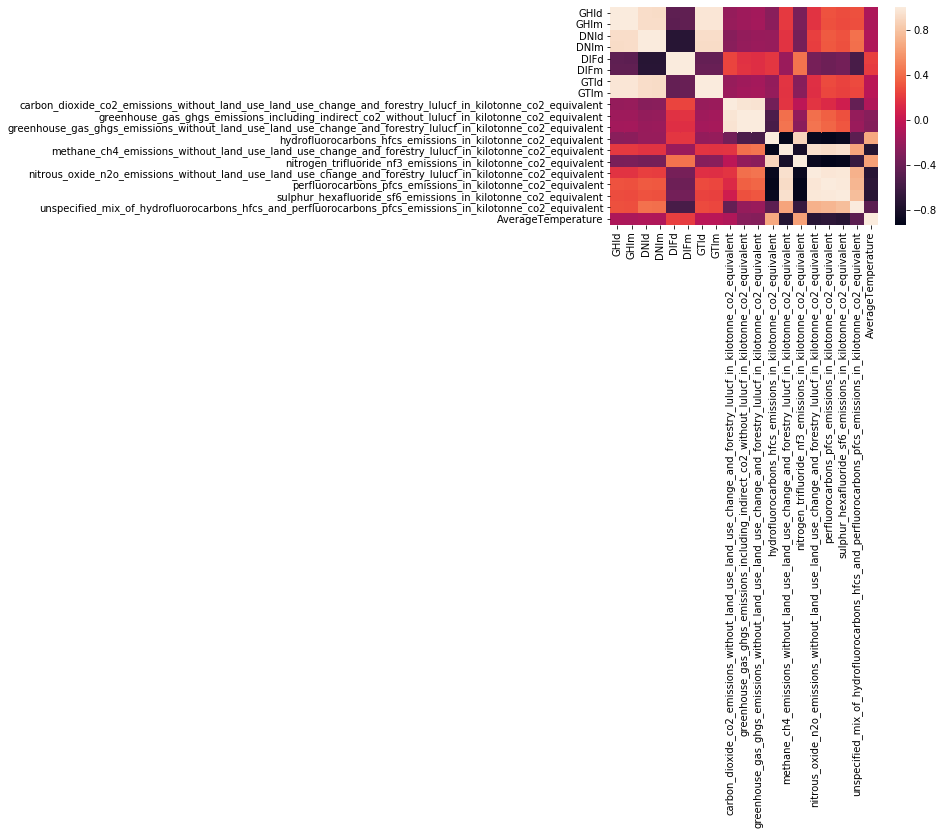

In [118]:
df_norm = (df -df.min())/(df.max()-df.min())
corrMatrix = df_norm.corr()
sn.heatmap(corrMatrix, annot=False)

# Model Selection

In [156]:
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor

In [157]:
X = df_norm.drop(['AverageTemperature'], axis=1)
y = df_norm['AverageTemperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Gradient Boosting

In [158]:
gb = ensemble.GradientBoostingRegressor()

model_gb = gb.fit(X_train, y_train)

predictions = model_gb.predict(X_test)
print ('RMSE is: \n', mean_squared_error(y_test, predictions))

RMSE is: 
 0.03646986633929231


#### Random forest

In [159]:
rf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=-1)

model_rf = rf.fit(X_train, y_train)

rf_pred = model_rf.predict(X_test)
print ('RMSE is: \n', mean_squared_error(y_test, rf_pred))

RMSE is: 
 0.03707110936325827


#### Lasso regression

In [160]:

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

lasso_pred_log = model_lasso.predict(X_test)
print ('RMSE is: \n', mean_squared_error(y_test, rf_pred))

RMSE is: 
 0.03707110936325827


#### Decision Tree

In [163]:
dt = DecisionTreeRegressor(random_state=0)
model_dt = dt.fit(X_train, y_train)

dt_pred = model_dt.predict(X_test)
print ('RMSE is: \n', mean_squared_error(y_test, dt_pred))

RMSE is: 
 0.06547640524572652


# Parameter optimisation for random forest

In [167]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

CPU times: user 20 µs, sys: 11 µs, total: 31 µs
Wall time: 34.1 µs


#### Random Forest: Random Search Cross Validation

In [169]:
%%time
#Hyperparameters
random_grid = {'n_estimators': [int(x) for x in np.linspace(200, 2000, num = 10)],# Number of trees in random forest
               'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)]+[None], # Maximum number of levels in tree
               'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
               'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
               'bootstrap': [True, False]} # Method of selecting samples for training each tree

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf , param_distributions = random_grid,
                               n_iter = 50, cv = 3, verbose=1, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


CPU times: user 1.89 s, sys: 104 ms, total: 1.99 s
Wall time: 1min 10s


In [170]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

#### Random Forest: Grid search

In [172]:
%%time
# Parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [ 8, 10, 12 ],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [ 1500, 1600, 1700]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  2.3min finished


CPU times: user 2.3 s, sys: 116 ms, total: 2.41 s
Wall time: 2min 20s


In [173]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1700}

# Model evaluation

In [174]:
def evaluate(model, X_test, y_test):
    rf_pred = model.predict(X_test)
    errors = abs(rf_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('RMSE: {:0.6f}'.format(mean_squared_error(y_test, rf_pred)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

print('Base model')
base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print('')

print('Parameter tuned with random search model')
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
print('')

print('Parameter tuned with grid search model')
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Base model
Model Performance
Average Error: 0.1615.
RMSE: 0.037831
Accuracy = 74.72%.

Parameter tuned with random search model
Model Performance
Average Error: 0.1436.
RMSE: 0.031880
Accuracy = 78.11%.
Improvement of 4.53%.

Parameter tuned with grid search model
Model Performance
Average Error: 0.1435.
RMSE: 0.031740
Accuracy = 78.17%.
Improvement of 4.62%.
